# Undercomplete autoencoders

In this notebook we explore the use of undercomplete autoencoders to compress data and synthesize new data.

A autoencoder, in its simplest form, is a neural network that is trained to match its output to its input.  The autoencoder is composed of two parts: an encoder $f$ and a decoder $g$.

$$\mathbf{x}_{out} = g(f(\mathbf{x}_{in}))$$

Here, both $f$ and $g$ will be implemented as multi-layer perceptrons, i.e. neural networks with multiple hidden layers and non-linear activation functions.

In an undercomplete autoencoder, the output of $f$ is smaller than the the input, so that the autoencoder learns to compress and decompress data.

In this notebook you will implement an undercomplete autoencoder and train it on the Frey dataset which contains about 2,000 faces of a single person's face with different poses and expressions.  Then you will explore how well the autoencoder can compress and decompress data, synthesize new data, and interpolate between faces.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt

## Data loading and pre-processing

Here we download and unpack the Frey dataset.  The dataset consists of grayscale images, 28 pixels high and 20 pixels wide.

In [2]:
from tensorflow.keras.utils import get_file
from scipy.io import loadmat

path = get_file('frey_rawface.mat','https://cs.nyu.edu/~roweis/data/frey_rawface.mat')
data = np.transpose(loadmat(path)['ff'])
images = np.reshape(data,(-1,28,20))
np.random.shuffle(images)

(1965, 28, 20)


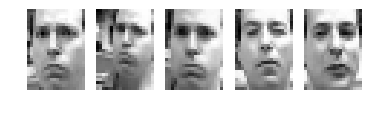

In [3]:
print(images.shape)
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(images[i])
  plt.axis('off')
plt.show()

We split the data into training and testing splits (the data was shuffled above) and then convert to floating point on [-1 1] range.

In [4]:
x_train = images[0:1800]
x_test = images[1800:]
x_train = (x_train.astype('float32')/255.)*2-1
x_test = (x_test.astype('float32')/255.)*2-1

## Model implementation and training

The code to build a linear autoencoder is given here.  Modify it to have multiple hidden layers with ReLU activation in the encoder and decoder.

### Encoder:
* Dense with 512 hidden units, ReLU activation
* Dense with 512 hidden units, ReLU activation
* Dense with 2 hidden units, tanh activation

### Decoder:
* Dense with 512 hidden units, ReLU activation
* Dense with 512 hidden units, ReLU activation
* Dense with 28*20 hidden units, linear activation


In [5]:
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

class Autoencoder:
  def __init__(self):
    # Encoder Layers
    self.e_d1 = Dense(512, activation='relu', name='encoder_dense_1')
    self.e_d2 = Dense(512, activation='relu', name='encoder_dense_2')
    self.encoder_layer = Dense(2,activation='tanh',name='encoder')
    # Decoder Layers
    self.d_d1 = Dense(512, activation='relu', name='decoder_dense_1')
    self.d_d2 = Dense(512, activation='relu', name='decoder_dense_2')
    self.decoder_layer = Dense(28*20,activation='linear',name='decoder')
    
  def get_autoencoder(self):
    """ Builds the full autoencoder model with encoder and decoder. """
    inputs = Input((28,20),name='autoencoder_input')
    x = Flatten()(inputs)
    x = self.e_d1(x)
    x = self.e_d2(x)
    x = self.encoder_layer(x)
    x = self.d_d1(x)
    x = self.d_d2(x)
    x = self.decoder_layer(x)
    outputs = Reshape((28,20))(x)
    return Model(inputs=inputs,outputs=outputs)
  
  def get_encoder(self):
    """ Builds just the encoder model. """
    inputs = Input((28,20),name='encoder_input')
    x = Flatten()(inputs)
    x = self.e_d1(x)
    x = self.e_d2(x)
    x = self.encoder_layer(x)
    return Model(inputs=inputs,outputs=x)
  
  def get_decoder(self):
    """ Builds just the decoder model. """
    embedding = Input((2,),name='decoder_input')
    x = embedding
    x = self.d_d1(x)
    x = self.d_d2(x)
    x = self.decoder_layer(x)
    outputs = Reshape((28,20))(x)
    return Model(inputs=embedding,outputs=outputs)

autoencoder = Autoencoder()

ae_model = autoencoder.get_autoencoder()
encoder_model = autoencoder.get_encoder()
decoder_model = autoencoder.get_decoder()

ae_model.compile(SGD(0.01,momentum=0.9),loss='mean_absolute_error')
print(ae_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 28, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 560)               0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 512)               287232    
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 512)               262656    
_________________________________________________________________
encoder (Dense)              (None, 2)                 1026      
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 512)               1536      
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 512)               262656    
__________

In [6]:
history = ae_model.fit(x_train,x_train,batch_size=32,epochs=1000,verbose=True,validation_split=0.1)

Train on 1620 samples, validate on 180 samples
Epoch 1/1000
1620/1620 [==============================] - 3s 2ms/step - loss: 0.3321 - val_loss: 0.3242
Epoch 2/1000
1620/1620 [==============================] - 0s 78us/step - loss: 0.3207 - val_loss: 0.3106
Epoch 3/1000
1620/1620 [==============================] - 0s 82us/step - loss: 0.3045 - val_loss: 0.2918
Epoch 4/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.2817 - val_loss: 0.2650
Epoch 5/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.2497 - val_loss: 0.2292
Epoch 6/1000
1620/1620 [==============================] - 0s 79us/step - loss: 0.2104 - val_loss: 0.1896
Epoch 7/1000
1620/1620 [==============================] - 0s 80us/step - loss: 0.1744 - val_loss: 0.1628
Epoch 8/1000
1620/1620 [==============================] - 0s 81us/step - loss: 0.1570 - val_loss: 0.1542
Epoch 9/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1518 - val_loss: 0.1518
Epoch 10/

1620/1620 [==============================] - 0s 78us/step - loss: 0.1467 - val_loss: 0.1480
Epoch 78/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1467 - val_loss: 0.1480
Epoch 79/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1466 - val_loss: 0.1479
Epoch 80/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1465 - val_loss: 0.1479
Epoch 81/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1464 - val_loss: 0.1478
Epoch 82/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1464 - val_loss: 0.1477
Epoch 83/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1463 - val_loss: 0.1476
Epoch 84/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1461 - val_loss: 0.1475
Epoch 85/1000
1620/1620 [==============================] - 0s 80us/step - loss: 0.1460 - val_loss: 0.1474
Epoch 86/1000
1620/1620 [==============================] - 0

1620/1620 [==============================] - 0s 76us/step - loss: 0.1288 - val_loss: 0.1324
Epoch 154/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1287 - val_loss: 0.1323
Epoch 155/1000
1620/1620 [==============================] - 0s 78us/step - loss: 0.1286 - val_loss: 0.1322
Epoch 156/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1286 - val_loss: 0.1321
Epoch 157/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1285 - val_loss: 0.1320
Epoch 158/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1284 - val_loss: 0.1319
Epoch 159/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1283 - val_loss: 0.1318
Epoch 160/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1283 - val_loss: 0.1317
Epoch 161/1000
1620/1620 [==============================] - 0s 78us/step - loss: 0.1282 - val_loss: 0.1317
Epoch 162/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 74us/step - loss: 0.1226 - val_loss: 0.1256
Epoch 230/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1225 - val_loss: 0.1256
Epoch 231/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1224 - val_loss: 0.1255
Epoch 232/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1224 - val_loss: 0.1255
Epoch 233/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1223 - val_loss: 0.1254
Epoch 234/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1223 - val_loss: 0.1254
Epoch 235/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1222 - val_loss: 0.1253
Epoch 236/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1222 - val_loss: 0.1253
Epoch 237/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1221 - val_loss: 0.1252
Epoch 238/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 76us/step - loss: 0.1191 - val_loss: 0.1222
Epoch 306/1000
1620/1620 [==============================] - 0s 71us/step - loss: 0.1190 - val_loss: 0.1222
Epoch 307/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1190 - val_loss: 0.1222
Epoch 308/1000
1620/1620 [==============================] - 0s 78us/step - loss: 0.1189 - val_loss: 0.1221
Epoch 309/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1189 - val_loss: 0.1221
Epoch 310/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1188 - val_loss: 0.1220
Epoch 311/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1188 - val_loss: 0.1220
Epoch 312/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1187 - val_loss: 0.1219
Epoch 313/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1187 - val_loss: 0.1219
Epoch 314/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 74us/step - loss: 0.1156 - val_loss: 0.1186
Epoch 382/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1155 - val_loss: 0.1186
Epoch 383/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1155 - val_loss: 0.1185
Epoch 384/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1154 - val_loss: 0.1185
Epoch 385/1000
1620/1620 [==============================] - 0s 72us/step - loss: 0.1154 - val_loss: 0.1184
Epoch 386/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1154 - val_loss: 0.1184
Epoch 387/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1153 - val_loss: 0.1183
Epoch 388/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1153 - val_loss: 0.1182
Epoch 389/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1152 - val_loss: 0.1182
Epoch 390/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 73us/step - loss: 0.1123 - val_loss: 0.1148
Epoch 458/1000
1620/1620 [==============================] - 0s 71us/step - loss: 0.1123 - val_loss: 0.1148
Epoch 459/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1122 - val_loss: 0.1147
Epoch 460/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1122 - val_loss: 0.1147
Epoch 461/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1121 - val_loss: 0.1146
Epoch 462/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1121 - val_loss: 0.1146
Epoch 463/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1121 - val_loss: 0.1145
Epoch 464/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1120 - val_loss: 0.1145
Epoch 465/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1120 - val_loss: 0.1145
Epoch 466/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 77us/step - loss: 0.1095 - val_loss: 0.1120
Epoch 534/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1095 - val_loss: 0.1120
Epoch 535/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1095 - val_loss: 0.1120
Epoch 536/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1094 - val_loss: 0.1119
Epoch 537/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1094 - val_loss: 0.1119
Epoch 538/1000
1620/1620 [==============================] - 0s 78us/step - loss: 0.1094 - val_loss: 0.1119
Epoch 539/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1094 - val_loss: 0.1119
Epoch 540/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1093 - val_loss: 0.1118
Epoch 541/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1093 - val_loss: 0.1118
Epoch 542/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 77us/step - loss: 0.1076 - val_loss: 0.1107
Epoch 610/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1076 - val_loss: 0.1107
Epoch 611/1000
1620/1620 [==============================] - 0s 73us/step - loss: 0.1076 - val_loss: 0.1107
Epoch 612/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1076 - val_loss: 0.1106
Epoch 613/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1075 - val_loss: 0.1106
Epoch 614/1000
1620/1620 [==============================] - 0s 72us/step - loss: 0.1075 - val_loss: 0.1106
Epoch 615/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1075 - val_loss: 0.1106
Epoch 616/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1075 - val_loss: 0.1106
Epoch 617/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1074 - val_loss: 0.1106
Epoch 618/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 71us/step - loss: 0.1062 - val_loss: 0.1100
Epoch 686/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1062 - val_loss: 0.1100
Epoch 687/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1062 - val_loss: 0.1100
Epoch 688/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1062 - val_loss: 0.1099
Epoch 689/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1061 - val_loss: 0.1099
Epoch 690/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1061 - val_loss: 0.1099
Epoch 691/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1061 - val_loss: 0.1099
Epoch 692/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1061 - val_loss: 0.1099
Epoch 693/1000
1620/1620 [==============================] - 0s 73us/step - loss: 0.1061 - val_loss: 0.1099
Epoch 694/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 76us/step - loss: 0.1051 - val_loss: 0.1095
Epoch 762/1000
1620/1620 [==============================] - 0s 78us/step - loss: 0.1051 - val_loss: 0.1095
Epoch 763/1000
1620/1620 [==============================] - 0s 80us/step - loss: 0.1050 - val_loss: 0.1095
Epoch 764/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1050 - val_loss: 0.1095
Epoch 765/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1050 - val_loss: 0.1095
Epoch 766/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1050 - val_loss: 0.1095
Epoch 767/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1050 - val_loss: 0.1095
Epoch 768/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1050 - val_loss: 0.1096
Epoch 769/1000
1620/1620 [==============================] - 0s 78us/step - loss: 0.1050 - val_loss: 0.1095
Epoch 770/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 79us/step - loss: 0.1041 - val_loss: 0.1090
Epoch 838/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1040 - val_loss: 0.1090
Epoch 839/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1040 - val_loss: 0.1090
Epoch 840/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1040 - val_loss: 0.1090
Epoch 841/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1040 - val_loss: 0.1090
Epoch 842/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1040 - val_loss: 0.1090
Epoch 843/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1040 - val_loss: 0.1090
Epoch 844/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1040 - val_loss: 0.1090
Epoch 845/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1040 - val_loss: 0.1090
Epoch 846/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 81us/step - loss: 0.1031 - val_loss: 0.1086
Epoch 914/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1031 - val_loss: 0.1085
Epoch 915/1000
1620/1620 [==============================] - 0s 79us/step - loss: 0.1031 - val_loss: 0.1085
Epoch 916/1000
1620/1620 [==============================] - 0s 80us/step - loss: 0.1031 - val_loss: 0.1086
Epoch 917/1000
1620/1620 [==============================] - 0s 84us/step - loss: 0.1031 - val_loss: 0.1086
Epoch 918/1000
1620/1620 [==============================] - 0s 86us/step - loss: 0.1031 - val_loss: 0.1085
Epoch 919/1000
1620/1620 [==============================] - 0s 82us/step - loss: 0.1030 - val_loss: 0.1086
Epoch 920/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1030 - val_loss: 0.1085
Epoch 921/1000
1620/1620 [==============================] - 0s 74us/step - loss: 0.1030 - val_loss: 0.1085
Epoch 922/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 76us/step - loss: 0.1022 - val_loss: 0.1082
Epoch 990/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1022 - val_loss: 0.1081
Epoch 991/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1022 - val_loss: 0.1081
Epoch 992/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1022 - val_loss: 0.1081
Epoch 993/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1022 - val_loss: 0.1081
Epoch 994/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1022 - val_loss: 0.1081
Epoch 995/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1022 - val_loss: 0.1081
Epoch 996/1000
1620/1620 [==============================] - ETA: 0s - loss: 0.102 - 0s 77us/step - loss: 0.1022 - val_loss: 0.1081
Epoch 997/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1022 - val_loss: 0.1081
Epoch 998/1000
1620/1620 [==

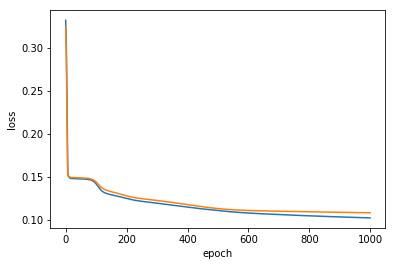

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Exercises

*Before doing any of these exercises, make sure to modify the model as described above.*

* Test the ability of the autoencoder to compress and decompress the images.  Compare some input images to their reconstructions after running the autoencoder.  What effect does the autoencoder have on the images?
* VIsualize the output of the encoder (run on the training data) as a scatter plot.  Give some observations about the output.  Does it seem to be using all of the possible output space?
* Generate new faces by making a grid of embedding points on $[-1~1]\times[-1~1]$ (see code below).  Give some observations about the resulting images.
* Test interpolation between two images (see the example from the autoencoder notebook).  Give some observations about the output.
* Set up another autoencoder and train it on the spiral data from HW1.1. Visualize the embedding that it produces.  Does it produce an embedding where the separate spirals are linearly separable?  Does the autoencoder learn to map the spirals to tight, separated clusters?  (You might want to use linear activation rather than tanh for the encoder output in this part.)

This code makes a 10x10 grid of points from -1 to 1 in each dimension.

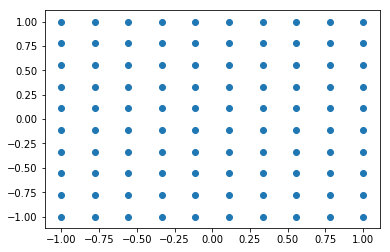

In [8]:
coords = np.linspace(-1,1,num=10)
x,y = np.meshgrid(coords,coords,indexing='xy')
embeddings = np.stack([x.flatten(),y.flatten()],axis=1)
plt.scatter(embeddings[:,0],embeddings[:,1])
plt.show()

##### 1. Test the ability of the autoencoder to compress and decompress the images. Compare some input images to their reconstructions after running the autoencoder. What effect does the autoencoder have on the images?

From the examples below, the autoencoder with multiple hidden layers is able to closely replicate the original images. One noticable difference is that the reconstructred images look slightly darker than the original images in areas that used to be white (check out the man's forehead) and the opposite affect is also true sometimes, as darker spots in the original image appear slightly lighter than the original representation. It appears that the largest differences between the original and the reconstructed images appear at the man's mouth. In the first and second reconstructed images, the tongue is no longer in the image. Overall, I was surprised that the autoencoder only obtained a loss of ~10% during validation since the encoder compresses the image into just two nodes!

Row 1 = Input Images
Row 2 = Reconstructed Images


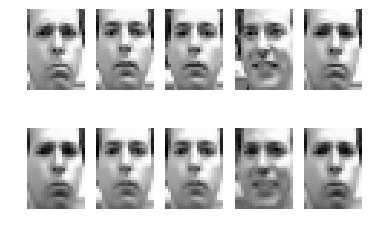

In [9]:
# Example input images and their reconstructions:
length = 5
images_in = x_test[:length]
# Run the autoencoder on each image
images_out = ae_model.predict(images_in)
print("Row 1 = Input Images\nRow 2 = Reconstructed Images")
# Display results
for i in range(length):
  plt.subplot(2,length,i+1)
  plt.imshow(images_in[i])
  plt.axis('off')
for i in range(length):
  plt.subplot(2,length,i+length+1)
  plt.imshow(images_out[i])
  plt.axis('off')
plt.show()

##### 2. Visualize the output of the encoder (run on the training data) as a scatter plot. Give some observations about the output. Does it seem to be using all of the possible output space?

When the latent values are plotted in two dimensions, the training data appears to be clustered in three different areas. The first cluster is a large arc across the top, the second cluster is a smaller arc slight below the first arc, and the third cluster is a pocket between the first two arcs where Y is between [-1.0, 0.0] and X is between [-1.0, -0.5]. There does not seem to be a clear distribution throughout the scatterplot, so it would be difficult to sample points from the latent vector. Hopefully with a variational autoencoder we will observe a more random distribution.

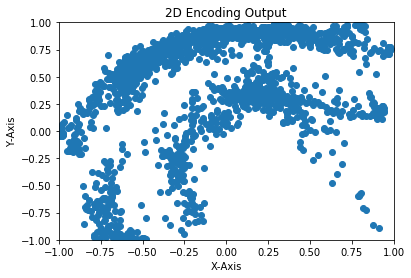

In [10]:
images_out = encoder_model.predict(x_train)
x = [x[0] for x in images_out]
y = [x[1] for x in images_out]
plt.scatter(x, y)
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title("2D Encoding Output")
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

##### 3. Generate new faces by making a grid of embedding points on  [−1 1]×[−1 1]  (see code below). Give some observations about the resulting images.

Sampling images across the entire output space gives us an idea of how the decoder is working. I have observed the following trends:
    1. The man's face changes directions from right to left across the main diagonal.
    2. The man's mouth changes from a blurry tongue-like figure to a smile across the "off-diagonal" (the bottom left images to the top right image).
    3. The man's tongue is not completely visible in any of the images.
    4. The man's face faces directly at the camera in the center of the matrix.

PS: Sorry for the small images. I could not figure out how to make them bigger :(

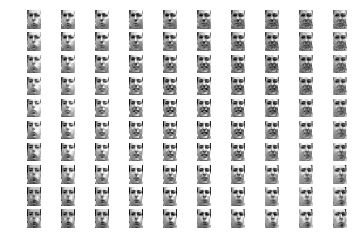

In [11]:
# Generate an image from each area in the output space
embeddings.shape
images = decoder_model.predict(embeddings)

width = height = 10
totalPoints = width * height
for i in range(totalPoints):
  plt.subplot(width,height,i+1)
  plt.imshow(np.squeeze(images[i]))
  plt.axis('off')

##### 4. Test interpolation between two images (see the example from the autoencoder notebook). Give some observations about the output.

The output of my function, interpolate_between(imgA_index, imgB_index), is as follows: The first row of images represents the output images for the autoencoder and the bottom two images in the second row are the original images from which we are interpolating between.

I have chosen to interpolate between two different pairs of images:

First Pair: 

Image 1 = The man is sticking his tongue out and facing to the right 

Image 2 = The man is sticking his tongue out and is facing towards the camera. 

In the interpolation, none of the images show the tongue. However, the man slowly turns his head to face the camera. 

Second Pair: 
Image 1 = The man is frowning and facing towards the camera.

Image 2 = The man is smiling and facing towards the camera. 

As you can see, the output images of the autoencoder transforms the frown into a smile by gradually opening and reshaping his lips.

I found the output of both interpolations very interesting because the autoencoder creates smooth transitions between the two images!

In [12]:
def interpolate_between(imgA_index,imgB_index):
  imgA = x_test[imgA_index]
  imgB = x_test[imgB_index]
  
  imgA_encoded = encoder_model.predict(x_test[imgA_index:(imgA_index+1)])
  imgB_encoded = encoder_model.predict(x_test[imgB_index:(imgB_index+1)])
  
  numAlphas = 10
  alphas = np.linspace(0,1,num=numAlphas)
  for n in range(10):
    alpha = alphas[n]
    img_encoded = (1-alpha)*imgA_encoded+alpha*imgB_encoded
    img = decoder_model.predict(img_encoded)
    plt.subplot(2,10,n+1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
  plt.subplot(2,10,numAlphas+1)
  plt.imshow(np.squeeze(imgA))
  plt.axis('off')
  plt.subplot(2,10,numAlphas+2)
  plt.imshow(np.squeeze(imgB))
  plt.axis('off')
  plt.subplots_adjust(top = 0.5, bottom=0, hspace=0, wspace=0.4)
  plt.show()

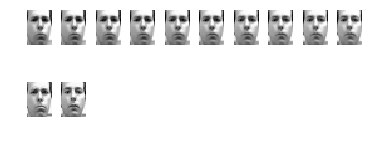

In [13]:
interpolate_between(0,1)

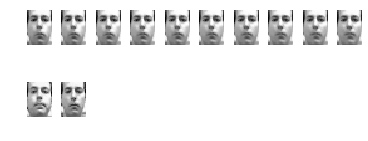

In [14]:
interpolate_between(5,14)

##### 5. Set up another autoencoder and train it on the spiral data from HW1.1. Visualize the embedding that it produces. Does it produce an embedding where the separate spirals are linearly separable? Does the autoencoder learn to map the spirals to tight, separated clusters? (You might want to use linear activation rather than tanh for the encoder output in this part.)

In my implementation, I compare the results from four different autoencoders where the size of the latent vector varies between one and two and the activation of the encoding layer is either tanh and linear:
1. Embedding Size = 2 + Activation = linear
1. Embedding Size = 2 + Activation = tanh
1. Embedding Size = 1 + Activation = linear
1. Embedding Size = 1 + Activation = tanh

Overall, none of the variations produced spiral embeddings that were linearly separable or mapped into tight, separated clusters. 

As for individual evaluations, when two neurons are used in the latent layer, the shape of the graphed embeddings resembled the original spirals. When using an embedding size of two and linear activations, the embedding closely resembled the original sprial. When using an embedding size of two and tanh activations, the spiral appeared deformed because the tanh activation function forces all the points to fit into a smaller grid. When the size of the embedding was reduced to one neuron, no noticable clusters formed that were linearly separable in the linear model. In the tanh model, there does seem to be some separation, but this could had occured by chance.

Shape of integer labels:  (312,)
Shape of one hot labels:  (312, 3)
Label as integer: 1.0
Label as one hot vector:  [0. 1. 0.]
Mean of x before centering:  [18.40817308 16.34471154]
Mean of x after centering:  [-1.11250041e-14 -3.81461244e-15]


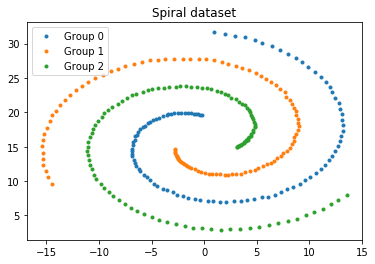

In [15]:
import urllib.request
import tempfile
import shutil
from tensorflow.keras.utils import to_categorical
# get data from web and store to temporary file
with urllib.request.urlopen('http://cs.joensuu.fi/sipu/datasets/spiral.txt') as response:
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        shutil.copyfileobj(response, tmp_file)
data = np.loadtxt(tmp_file.name,delimiter='\t') # load data into numpy array
np.random.shuffle(data)  # shuffle the data so that the examples are randomly ordered
x = data[:,0:2] # extract the 2D coordinates of the points
y = data[:,2]-1 # extract the class labels and convert to zero-based indexing

y_onehot = to_categorical(y,3)
print('Shape of integer labels: ',y.shape)
print('Shape of one hot labels: ',y_onehot.shape)
print('Label as integer:',y[0])
print('Label as one hot vector: ',y_onehot[0])

x_zerocentered = x - np.mean(x,axis=0,keepdims=True)
print('Mean of x before centering: ',np.mean(x,axis=0))
print('Mean of x after centering: ',np.mean(x_zerocentered,axis=0))

for i in range(3):
    sel = y_onehot[:,i]==1
    plt.plot(x_zerocentered[sel,0],x[sel,1],'.',label='Group %d'%i)
plt.title('Spiral dataset')
plt.legend()
plt.show()

In [16]:
class AutoencoderForSpiralDataset:
  def __init__(self, encoder_size=2, encoder_activation='linear'):
    self.encoder_size = encoder_size
    # Encoder Layers
    self.e_d1 = Dense(512, activation='relu', name='encoder_dense_1')
    self.e_d2 = Dense(512, activation='relu', name='encoder_dense_2')
    self.encoder_layer = Dense(encoder_size,activation=encoder_activation,name='encoder')
    # Decoder Layers
    self.d_d1 = Dense(512, activation='relu', name='decoder_dense_1')
    self.d_d2 = Dense(512, activation='relu', name='decoder_dense_2')
    self.decoder_layer = Dense(2,activation='linear',name='decoder')
    
  def get_autoencoder(self):
    """ Builds the full autoencoder model with encoder and decoder. """
    inputs = Input((2,),name='autoencoder_input')
    x = Flatten()(inputs)
    x = self.e_d1(x)
    x = self.e_d2(x)
    x = self.encoder_layer(x)
    x = self.d_d1(x)
    x = self.d_d2(x)
    x = self.decoder_layer(x)
    outputs = Reshape((2,))(x)
    return Model(inputs=inputs,outputs=outputs)
  
  def get_encoder(self):
    """ Builds just the encoder model. """
    inputs = Input((2,),name='encoder_input')
    x = Flatten()(inputs)
    x = self.e_d1(x)
    x = self.e_d2(x)
    x = self.encoder_layer(x)
    return Model(inputs=inputs,outputs=x)
  
  def get_decoder(self):
    """ Builds just the decoder model. """
    embedding = Input((self.encoder_size,),name='decoder_input')
    x = embedding
    x = self.d_d1(x)
    x = self.d_d2(x)
    x = self.decoder_layer(x)
    outputs = Reshape((2,))(x)
    return Model(inputs=embedding,outputs=outputs)

def AutoencoderSpiralFactory(encoder_size, encoder_activation):
    autoencoder_sd = AutoencoderForSpiralDataset(encoder_size, encoder_activation)
    ae_model_sd = autoencoder_sd.get_autoencoder()
    encoder_model_sd = autoencoder_sd.get_encoder()
    decoder_model_sd = autoencoder_sd.get_decoder()
    ae_model_sd.compile(SGD(0.01,momentum=0.9),loss='mean_absolute_error')
    print(ae_model_sd.summary())
    history = ae_model_sd.fit(x_zerocentered,x_zerocentered,batch_size=32,epochs=250,verbose=False,validation_split=0.1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    return ae_model_sd, encoder_model_sd, decoder_model_sd

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 2)                 0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2)                 0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 512)               1536      
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 512)               262656    
_________________________________________________________________
encoder (Dense)              (None, 2)                 1026      
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 512)               1536      
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 512)               262656    
__________

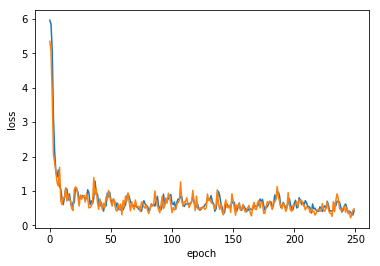

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 2)                 0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2)                 0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 512)               1536      
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 512)               262656    
_________________________________________________________________
encoder (Dense)              (None, 2)                 1026      
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 512)               1536      
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 512)               262656    
__________

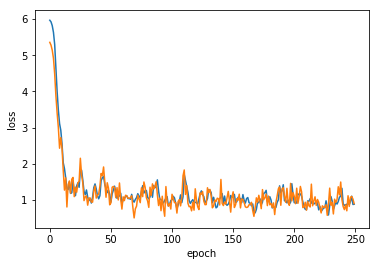

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 2)                 0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2)                 0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 512)               1536      
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 512)               262656    
_________________________________________________________________
encoder (Dense)              (None, 1)                 513       
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 512)               1024      
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 512)               262656    
__________

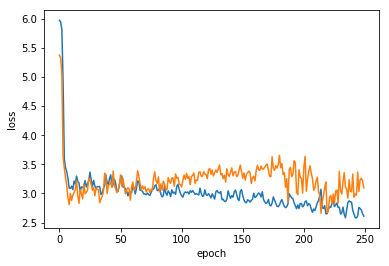

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 2)                 0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2)                 0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 512)               1536      
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 512)               262656    
_________________________________________________________________
encoder (Dense)              (None, 1)                 513       
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 512)               1024      
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 512)               262656    
__________

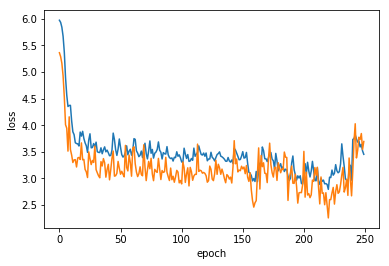

In [17]:
model_2_linear, encoder_2_linear, decoder_2_linear = AutoencoderSpiralFactory(2, "linear")
model_2_tanh, encoder_2_tanh, decoder_2_tanh = AutoencoderSpiralFactory(2, "tanh")
model_1_linear, encoder_1_linear, decoder_1_linear = AutoencoderSpiralFactory(1, "linear")
model_1_tanh, encoder_1_tanh, decoder_1_tanh = AutoencoderSpiralFactory(1, "tanh")

In [20]:
def graph_2Dencodings(title, encoder, ylim, xlim):
    images_out = encoder.predict(x_zerocentered)
    print("Output Shape:" + str(images_out.shape))
    x = [x[0] for x in images_out]
    y = [x[1] for x in images_out]
    plt.scatter(x, y)
    plt.xlabel("X-Axis")
    plt.ylabel("Y-Axis")
    plt.title(title)
    plt.ylim(ylim[0],ylim[1])
    plt.xlim(xlim[0],xlim[1])
    plt.show()
    
def graph_1Dencodings(title, encoder, ylim, xlim):
    images_out = encoder.predict(x_zerocentered)
    print("Output Shape:" + str(images_out.shape))
    x = [x[0] for x in images_out]
    y = [0 for x in images_out]
    plt.scatter(x, y)
    plt.xlabel("X-Axis")
    plt.ylabel("Y-Axis")
    plt.title(title)
    plt.ylim(ylim[0],ylim[1])
    plt.xlim(xlim[0],xlim[1])
    plt.show()

Output Shape:(312, 2)


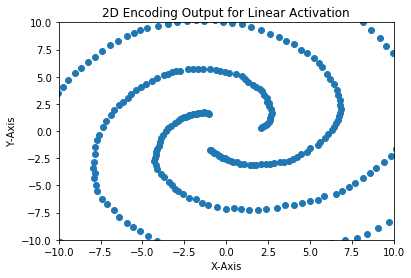

Output Shape:(312, 2)


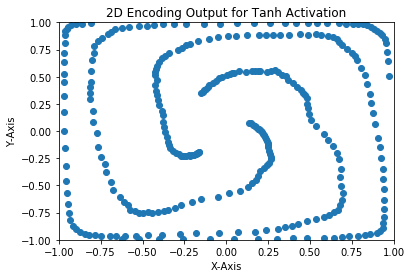

Output Shape:(312, 1)


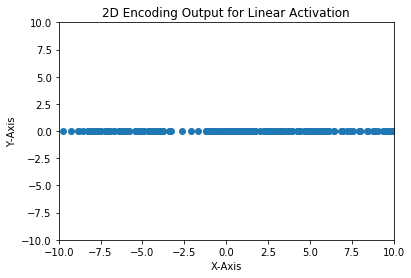

Output Shape:(312, 1)


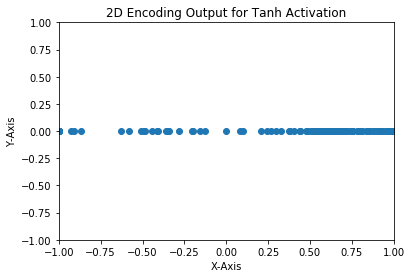

In [21]:
graph_2Dencodings("2D Encoding Output for Linear Activation", encoder_2_linear, [-10,10], [-10,10])
graph_2Dencodings("2D Encoding Output for Tanh Activation", encoder_2_tanh, [-1,1], [-1,1])
graph_1Dencodings("2D Encoding Output for Linear Activation", encoder_1_linear, [-10,10], [-10,10])
graph_1Dencodings("2D Encoding Output for Tanh Activation", encoder_1_tanh, [-1,1], [-1,1])